In [1]:
#import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from lesson_functions import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from scipy.spatial.distance import euclidean
from collections import deque
%matplotlib inline


In [2]:
testImagesPath = "./output_images/test_images"

outCarNotCarPath = testImagesPath + "/carNotCars"
if not os.path.exists(outCarNotCarPath):
    if not os.path.exists(testImagesPath):
        os.mkdir(testImagesPath)
    os.mkdir(outCarNotCarPath)

outHogPath = testImagesPath + "/hog"
if not os.path.exists(outHogPath):
    if not os.path.exists(testImagesPath):
        os.mkdir(testImagesPath)
    os.mkdir(outHogPath)
    
outSlidingWindowPath = testImagesPath + "/slidingWindows"
if not os.path.exists(outSlidingWindowPath):
    if not os.path.exists(testImagesPath):
        os.mkdir(testImagesPath)
    os.mkdir(outSlidingWindowPath)
    
outFinalPath = testImagesPath + "/final"
if not os.path.exists(outFinalPath):
    if not os.path.exists(testImagesPath):
        os.mkdir(testImagesPath)
    os.mkdir(outFinalPath)    


In [3]:
videoExtractFramePath = "./video_frames"
if not os.path.exists(videoExtractFramePath):
    os.mkdir(videoExtractFramePath)

videoFramePath = "./output_images/video_frames"  
if not os.path.exists(videoFramePath):
    os.mkdir(videoFramePath) 
    
outVideoPath = "./output_images/video" 
if not os.path.exists(outVideoPath):
    os.mkdir(outVideoPath) 


In [4]:
def loadData(folder):
    cars = []
    notcars = []
    for dirpath, dirnames, files in os.walk(folder):
        if 'non-vehicles' in dirpath:
            for image in files:
                notcars.append(os.path.join(dirpath, image))
        else:
            for image in files:
                cars.append(os.path.join(dirpath, image))
    return cars, notcars

def loadTestData(folder):
    data = []
    for file in os.listdir(folder):
        data.append(folder + file)
    return np.array(data)

# Define a function to return some characteristics of the dataset 
def dataLook(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "nCars" and store the number of car images
    data_dict["nCars"] = len(car_list)
    # Define a key "nNotCars" and store the number of notcar images
    data_dict["nNotCars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "imageShape" and store the test image shape 3-tuple
    sample = cv2.imread(car_list[0])
    data_dict["imageShape"] = sample.shape
    # Define a key "dataType" and store the data type of the test image.
    data_dict["dataType"] = sample.dtype
    # Return data_dict
    return data_dict


### Read Dataset

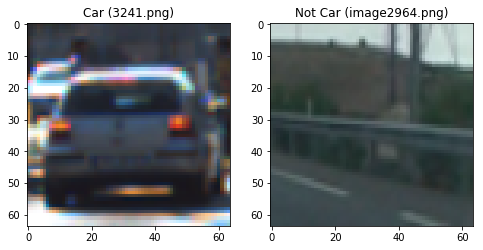

In [5]:
carsList, notCarsList = loadData("data")
dataInfo = dataLook(carsList, notCarsList)
carIndex = np.random.randint(0, len(carsList))
notCarIndex = np.random.randint(0, len(notCarsList))

carImage = mpimg.imread(carsList[carIndex])
notCarImage = mpimg.imread(notCarsList[notCarIndex])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.set_title('Car (' + carsList[carIndex].split('\\')[-1] + ')')
ax1.imshow(carImage)
ax2.set_title('Not Car (' + notCarsList[notCarIndex].split('\\')[-1] + ')')
ax2.imshow(notCarImage)
fig.savefig(outCarNotCarPath + '/car_not_car.jpg', bbox_inches='tight')


### HOG Feature Extraction

C:\Users\Ong Whee Cheng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


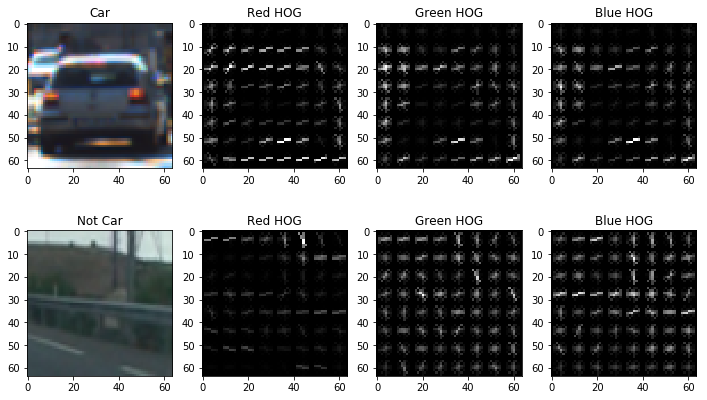

In [6]:
# Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Car
car = np.copy(carImage)
car = cv2.cvtColor(car, cv2.COLOR_RGB2YCrCb)
_, carHog1 = get_hog_features(car[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, carHog2 = get_hog_features(car[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, carHog3 = get_hog_features(car[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Not car
notCar = np.copy(notCarImage)
notCar = cv2.cvtColor(notCar, cv2.COLOR_RGB2YCrCb)
_, notCarHog1 = get_hog_features(notCar[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, notCarHog2 = get_hog_features(notCar[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, notCarHog3 = get_hog_features(notCar[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 7))
ax1.set_title('Car')
ax1.imshow(carImage)
ax2.set_title('Red HOG')
ax2.imshow(carHog1, cmap='gray')
ax3.set_title('Green HOG')
ax3.imshow(carHog2, cmap='gray')
ax4.set_title('Blue HOG')
ax4.imshow(carHog3, cmap='gray')
ax5.set_title('Not Car')
ax5.imshow(notCarImage)
ax6.set_title('Red HOG')
ax6.imshow(notCarHog1, cmap='gray')
ax7.set_title('Green HOG')
ax7.imshow(notCarHog2, cmap='gray')
ax8.set_title('Blue HOG')
ax8.imshow(notCarHog3, cmap='gray')

fig.savefig(outHogPath + '/HOG.jpg', bbox_inches='tight')


In [7]:
svc = joblib.load('svm\svc.pkl')
X_scaler = joblib.load('svm\scaler.pkl')

scales = [(96, 64), (192, 128), (288, 192)]
overlaps = [0.9, 0.8, 0.6]
y_start_stops = [[380, 520], [380, 600], [400, 690]]
x_start_stops = [[250, None], [225, None], [200, None]]
colors = [(0,255,0), (0,255,255), (255,255,0)]  # green, cyan, yellow


### Sliding Window (Multi-Scale)

In [8]:
def slideWindow(arg, video = False, conv=True, save=False):
    if video:
        image = arg
    else:
        image = mpimg.imread(arg)
    draw_image = np.copy(image)
    if conv:
        image = image.astype(np.float32)/255
    
    # multi-scale sliding windows
    box_list = []
    for scale, overlap, color, y_start_stop, x_start_stop in zip(scales, overlaps, colors, y_start_stops, x_start_stops):
    
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=scale, xy_overlap=(overlap, overlap))
    
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)                       
        draw_image = draw_boxes(draw_image, hot_windows, color=color, thick=3) 
        box_list += hot_windows
    
    if save:
        fig, ax = plt.subplots(nrows=1, figsize=(5, 3))
        ax.set_title(arg.split('/')[-1])
        ax.imshow(draw_image)
        fig.savefig(outSlidingWindowPath + '/' + arg.split('/')[-1], bbox_inches='tight')
    return box_list, draw_image


### Heat Map

In [9]:
heatmap_history = deque(maxlen=5)

def drawLabeledBboxes(img, labels, video=True):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    return img    

def processHeatMap(image, boxes, video=True, threshold=7):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    if video:
        global heatmap_history
        heatmap_history.append(heat)
        heat = np.sum(np.array(heatmap_history), axis=0)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = drawLabeledBboxes(np.copy(image), labels, video)  
    return draw_img, heatmap, labels


### Detect Cars

In [10]:
def detectCars(arg, video = True, save_image = False, save_vframe = False, threshold=7):
    if video:
        ret_image = np.copy(arg)
    else:
        ret_image = mpimg.imread(arg)

    box_list, draw_image = slideWindow(arg=arg, video=video, conv=True, save=False)
    ret_image, ret_heatmap, ret_labels = processHeatMap(ret_image, box_list,  video, threshold)
    
    if save_image or save_vframe:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 7))
        # bounding boxes and heat map
        ax1.set_title(arg.split('/')[-1])
        ax1.imshow(draw_image)
        ax2.set_title('Heat Map')
        ax2.imshow(ret_heatmap, cmap='hot')
        # labels and car positions
        if ret_labels[1] > 1:
            ax3.set_title(str(ret_labels[1]) + ' cars found (' + file.split('/')[-1] + ')')
        else:
            ax3.set_title(str(ret_labels[1]) + ' car found (' + file.split('/')[-1] + ')')
        ax3.imshow(ret_labels[0], cmap='gray')
        ax4.set_title('Car Positions (' + file.split('/')[-1] + ')')
        ax4.imshow(ret_image)
        if save_image:
            fig.savefig(outFinalPath + '/' + arg.split('/')[-1], bbox_inches='tight')
        else:
            fig.savefig(videoFramePath + '/' + arg.split('/')[-1], bbox_inches='tight')
    return ret_image


C:\Users\Ong Whee Cheng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


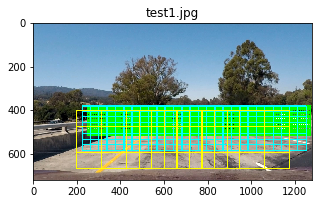

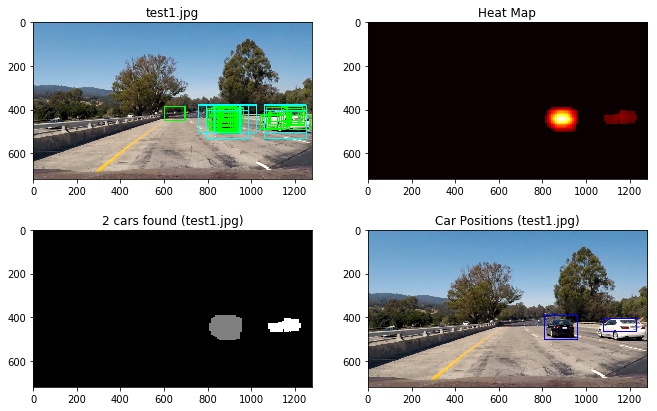

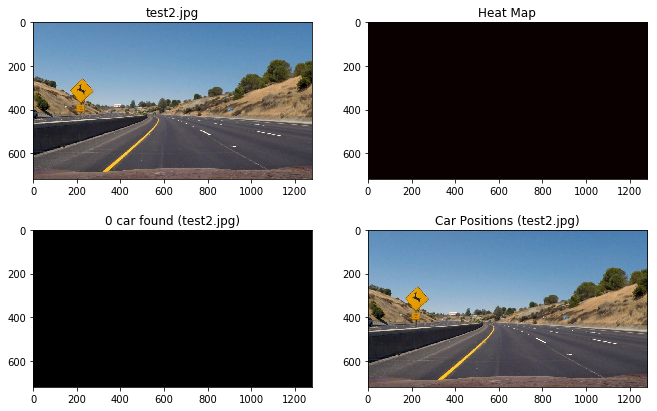

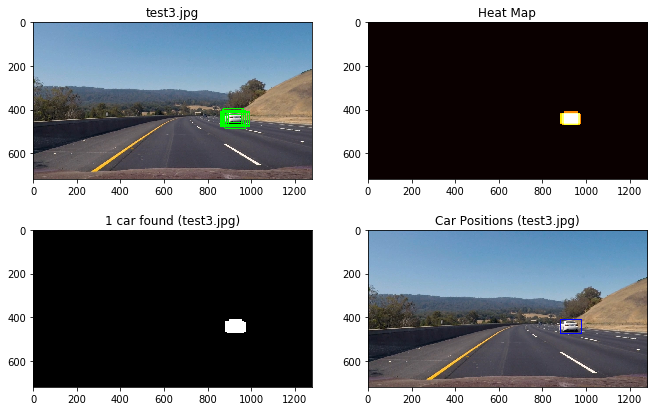

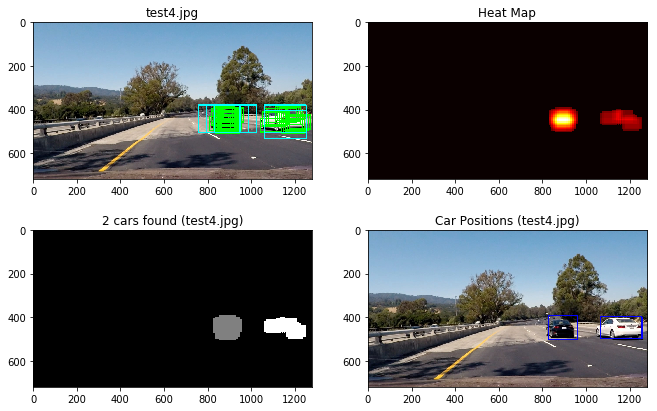

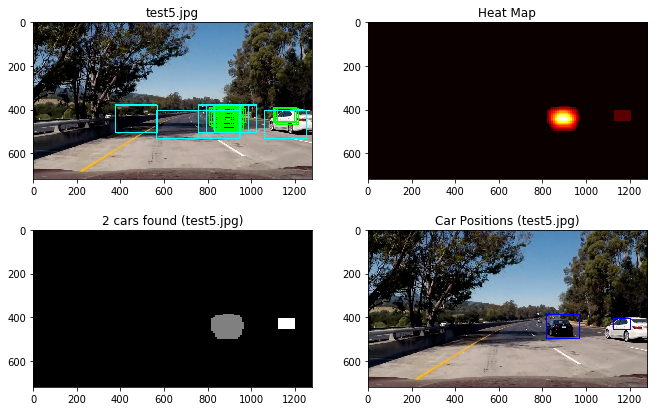

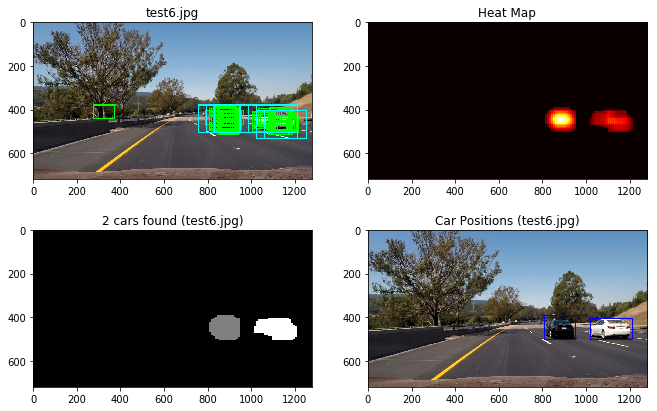

In [11]:
testImages = loadTestData("test_images/")
slideWindow(arg=testImages[0], video=False, conv=False, save=True)
for file in testImages:
    heatmap_history.clear()
    detectCars(arg=file, video=False, save_image=True, save_vframe=False)
   

### Process Video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [13]:
# Extract 6 frames from video, starting from t=28s
clip1 = VideoFileClip("./project_video.mp4")
for i in range(6):
    time = 28 + i/25.  # frame rate = 25fps
    filename = "frame @ t={:.2f}".format(time) + "s.jpg"
    projectFrameOutput = os.path.join(videoExtractFramePath, filename)    
    video_clip = clip1.save_frame(projectFrameOutput, t=time) # saves the frame 
    

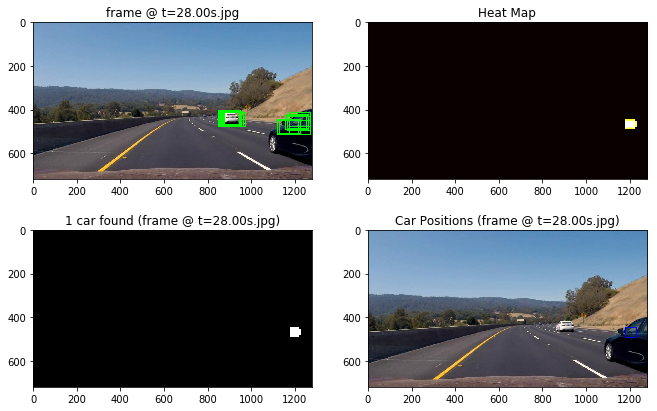

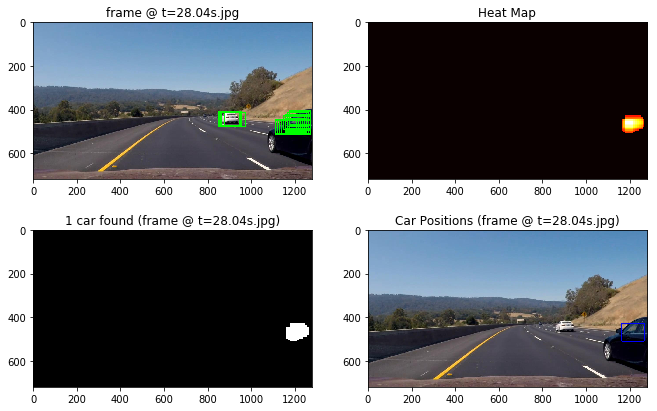

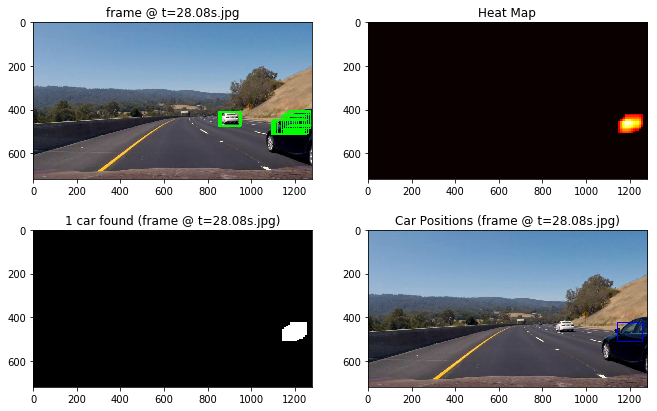

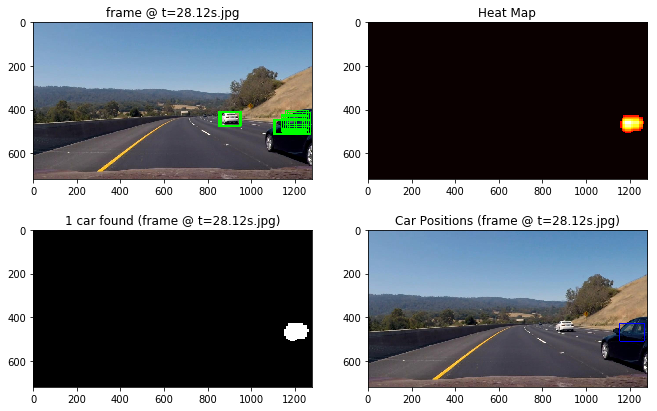

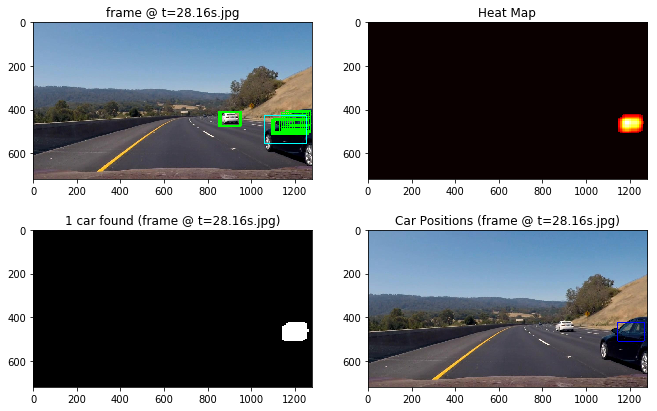

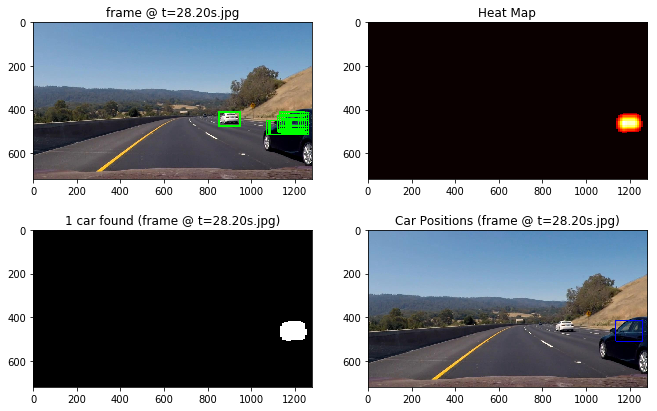

In [14]:
videoFrames = loadTestData("video_frames/")
for file in videoFrames:
    heatmap_history.clear()
    detectCars(arg=file, video=False, save_image=False, save_vframe=True)
 

In [15]:
filename = "project_video_output.mp4"
projectVideoOutput = os.path.join(outVideoPath, filename)    
    
clip1 = VideoFileClip("./project_video.mp4")
heatmap_history.clear()
video_clip = clip1.fl_image(detectCars) #NOTE: this function expects color images!!
%time video_clip.write_videofile(projectVideoOutput, audio=False)    


[MoviePy] >>>> Building video ./output_images/video\project_video_output.mp4
[MoviePy] Writing video ./output_images/video\project_video_output.mp4


100%|█████████▉| 1260/1261 [3:58:40<00:11, 11.89s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/video\project_video_output.mp4 

Wall time: 3h 58min 42s
